In [1]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import pandas as pd
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import netCDF4
# from netCDF4 import *

import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from scipy import interpolate
from scipy.interpolate import griddata
import time
import glob
import dask

from scipy.fftpack import fft
from scipy.fftpack import ifft
import copy
import eofs.standard as Eof_st
from matplotlib.colors import ListedColormap

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import cmocean

## Band Pass filter

In [78]:
#band pass filter
def filt_band(ts,band_high_ind,band_low_ind):
    Z = np.fft.fft(ts)
    Zlow = np.copy(Z)
    Zlow[:band_low_ind] = 0.0
    Zlow[band_high_ind:-band_high_ind] = 0.0
    Zlow[-band_low_ind:] = 0.0
    X_filtered = np.real(np.fft.ifft(Zlow))
    return X_filtered


# example:

# sampling_rate = 1000  # Hz
# data_length = len(ts)  # Length of your time-series data
# desired_low_frequency = 10  # Hz
# desired_high_frequency = 20  # Hz

# band_low_ind = int(desired_low_frequency * (data_length / sampling_rate))
# band_high_ind = int(desired_high_frequency * (data_length / sampling_rate))

## Open 1

In [92]:
ls -lathr /glade/scratch/wchapman/data_for_KJM/

total 873G
-rw-r--r--   1 wchapman ncar 5.1G Aug  7 10:33 FLUT_train_dask.nc
-rw-r--r--   1 wchapman ncar 5.1G Aug  7 10:39 FLUT_val_dask.nc
-rw-r--r--   1 wchapman ncar 5.1G Aug  7 10:45 FLUT_test_dask.nc
-rw-r--r--   1 wchapman ncar 4.2G Aug  7 10:49 Z500_train_dask.nc
-rw-r--r--   1 wchapman ncar 4.1G Aug  7 10:54 Z500_val_dask.nc
-rw-r--r--   1 wchapman ncar 4.1G Aug  7 10:58 Z500_test_dask.nc
-rw-r--r--   1 wchapman ncar  12G Aug  7 12:41 U_train_dask.nc
-rw-r--r--   1 wchapman ncar  12G Aug  7 12:54 U_val_dask.nc
-rw-r--r--   1 wchapman ncar  12G Aug  7 13:06 U_test_dask.nc
-rw-r--r--   1 wchapman ncar  68G Aug  7 15:03 Z500_CESM2_BHIST_100_400_KJMmethod.nc
-rw-r--r--   1 wchapman ncar 164M Aug  7 15:44 SST_dask.nc
-rw-r--r--   1 wchapman ncar  15G Aug  8 07:46 FLUT_CESM2_100_400.nc
-rw-r--r--   1 wchapman ncar  35G Aug  8 09:53 U_CESM2_100_400.nc
-rw-r--r--   1 wchapman ncar 364M Aug  8 11:37 MJO_CESM2_OLR_0100_0400.nc
-rw-r--r--   1 wchapman ncar  46G Aug  8 14:59 SST_CESM2_100

# FLUT

In [4]:
DS = xr.open_dataset('/glade/scratch/wchapman/data_for_KJM/FLUT_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc')
DS['FLUT_ANOM'] = DS['FLUT'] - DS['FLUT_climo']

In [56]:
sampling_rate = (1/86400)  # Hz
data_length = len(ts)  # Length of your time-series data
desired_low_frequency = sampling_rate/90  # Hz
desired_high_frequency = sampling_rate/30  # Hz

band_low_ind = int(desired_low_frequency * (data_length / sampling_rate))
band_high_ind = int(desired_high_frequency * (data_length / sampling_rate))

def filt_band(ts,band_high_ind,band_low_ind):
    Z = np.fft.fft(ts)
    Zlow = np.copy(Z)
    Zlow[:band_low_ind] = 0.0
    Zlow[band_high_ind:-band_high_ind] = 0.0
    Zlow[-band_low_ind:] = 0.0
    X_filtered = np.real(np.fft.ifft(Zlow))
    return X_filtered

#### Loop Through 

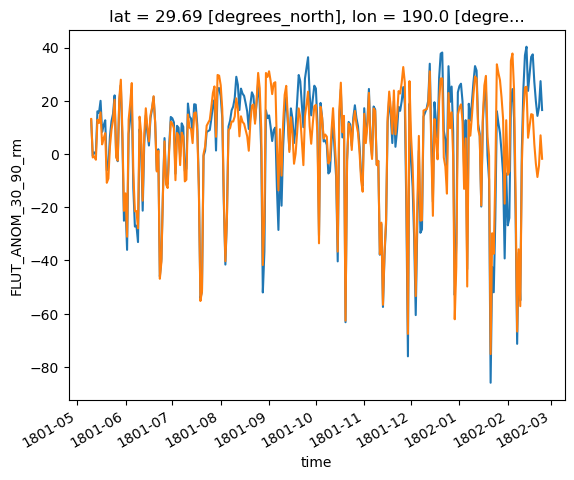

In [81]:
DS['FLUT_ANOM_30_90_rm'] = xr.zeros_like(DS['FLUT_ANOM'])
npflut = np.array(DS['FLUT_ANOM'])
print('go time')
for lala in range(192):
    
    print(lala)
    for lolo in range(288):
        ts_np = npflut[:,lala,lolo]
        ts_np_filt = filt_band(ts_np,band_high_ind,band_low_ind)
        DS['FLUT_ANOM_30_90_rm'][:,lala,lolo]=ts_np - ts_np_filt
DS.to_netcdf('/glade/scratch/wchapman/data_for_KJM/FLUT_filtered_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc')
DS['FLUT_ANOM'].sel(lat=30,lon=190,method='nearest').isel(time=slice(10,300)).plot()
DS['FLUT_ANOM_30_90_rm'].sel(lat=30,lon=190,method='nearest').isel(time=slice(10,300)).plot()
plt.show()

## Uwind 

In [84]:
DS = xr.open_dataset('/glade/scratch/wchapman/data_for_KJM/U200_U850_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc')
DS['U_ANOM'] = DS['U'] - DS['U_climo']

In [91]:
DS['U_ANOM_30_90_rm'] = xr.zeros_like(DS['U_ANOM'])
npflut = np.array(DS['U_ANOM'])
print('go time')
for lev in range(2):
    for lala in range(192):
        print(lala)
        for lolo in range(288):
            ts_np = npflut[:,lev,lala,lolo]
            ts_np_filt = filt_band(ts_np,band_high_ind,band_low_ind)
            DS['U_ANOM_30_90_rm'][:,lev,lala,lolo]=ts_np - ts_np_filt
DS.to_netcdf('/glade/scratch/wchapman/data_for_KJM/U_filtered_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc')
DS['U_ANOM'].sel(lat=30,lon=190,method='nearest').isel(time=slice(10,300)).plot()
DS['U_ANOM_30_90_rm'].sel(lat=30,lon=190,method='nearest').isel(time=slice(10,300)).plot()
plt.show()

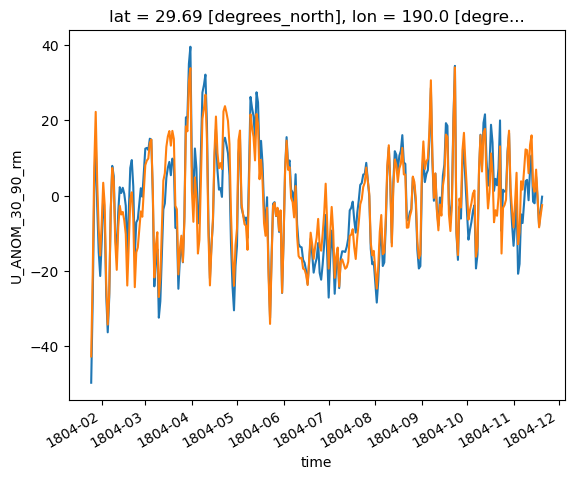

In [90]:
DS['U_ANOM'].sel(lat=30,lon=190,lev=200,method='nearest').isel(time=slice(1000,1300)).plot()
DS['U_ANOM_30_90_rm'].sel(lat=30,lon=190,lev=200,method='nearest').isel(time=slice(1000,1300)).plot()
plt.show()